# Kaggle Dog breed
Classify dog breed in Kaggle competition

In [1]:
!ls ../input/dog-breed-identification

labels.csv  sample_submission.csv  test  train


In [2]:
import numpy as np

original_train_dir = '../input/dog-breed-identification/train'
original_test_dir = '../input/dog-breed-identification/test'
train_labels = np.loadtxt('../input/dog-breed-identification/labels.csv', delimiter=',', dtype=str, skiprows=1)
# Remove missing data
train_labels = train_labels[train_labels[:, 0] != '000bec180eb18c7604dcecc8fe0dba07']
clazzes, counts = np.unique(train_labels[:, 1], return_counts=True)
print("Some classes with count:")
print(np.asarray((clazzes, counts)).T[0:10])
print("Number of class: %d" % clazzes.size)

Some classes with count:
[['affenpinscher' '80']
 ['afghan_hound' '116']
 ['african_hunting_dog' '86']
 ['airedale' '107']
 ['american_staffordshire_terrier' '74']
 ['appenzeller' '78']
 ['australian_terrier' '102']
 ['basenji' '110']
 ['basset' '82']
 ['beagle' '105']]
Number of class: 120


## Copy data
Keras has `ImageDataGenerator` with `flow_from_directory` as a source to make data augmentation. Below code will copy image to separate folder according to class name, which will be feed to ImageGenerator.

In [3]:
import os, shutil

def mkdirIfNotExist(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)
    return directory

base_dir = mkdirIfNotExist('./data_gen')
train_dir = mkdirIfNotExist(os.path.join(base_dir, 'train'))
validation_dir = mkdirIfNotExist(os.path.join(base_dir, 'validation'))
test_dir = mkdirIfNotExist(os.path.join(base_dir, 'test'))
for clazz in clazzes[:]:
    mkdirIfNotExist(os.path.join(train_dir, clazz))
    mkdirIfNotExist(os.path.join(validation_dir, clazz))

In [4]:
def copyIfNotExist(fnames, src_dir, dst_dir):
    nCopied = 0
    for fname in fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)
            nCopied += 1
    if nCopied > 0:
        print("Copied %d to %s" % (nCopied, dst_dir))

# This will split available labeled data to train-validation sets
train_ratio = 0.7
for clazz in clazzes[:]:
    fnames = train_labels[train_labels[:, 1] == clazz][:,0]
    fnames = ['{}.jpg'.format(name) for name in fnames]
    idx = int(len(fnames)*(1-train_ratio))
    val_fnames = fnames[:idx]
    train_fnames = fnames[idx:]
    train_class_dir = os.path.join(train_dir, clazz)
    validation_class_dir = os.path.join(validation_dir, clazz)
    copyIfNotExist(train_fnames, original_train_dir, train_class_dir)
    copyIfNotExist(val_fnames, original_train_dir, validation_class_dir)

## Data augmentation
I found out that using input image size as 299x299 is important for using pre-trained model with Xception. I tried with lower rescale size (249x249) and data is kind of bottleneck in 75% of accuracy. 299x299 give accuracy about 82%

In [5]:
from keras.preprocessing.image import ImageDataGenerator
img_width ,img_height = 299, 299
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')
total_train_image_count = train_generator.samples
class_count = train_generator.num_class

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
total_val_image_count = train_generator.samples

Using TensorFlow backend.


Found 7213 images belonging to 120 classes.
Found 3008 images belonging to 120 classes.


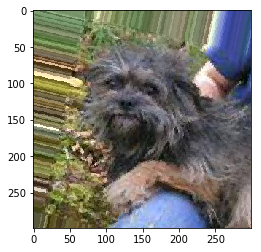

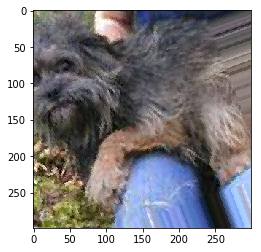

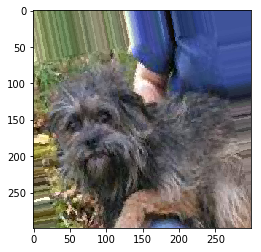

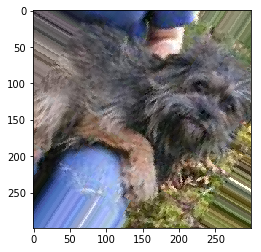

In [6]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

train_first_dir = os.path.join(train_dir, clazzes[0])
fnames = [os.path.join(train_first_dir, fname) for fname in os.listdir(train_first_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(img_width, img_height))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

## Extract feature with pretrained model

In [7]:
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

In [8]:
!cp ../input/keras-pretrained-models/* ~/.keras/models/

In [9]:
!ls ~/.keras/models

vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [10]:
from keras.applications.xception import Xception

conv_base = Xception(weights='imagenet',
                     include_top=False,
                     input_shape=(img_width, img_height, 3))
conv_base.trainable = False

## Define Neural Net

In [ ]:
from keras import layers, models, regularizers, optimizers
from keras.models import Sequential,  Model
from keras.layers import Flatten, Dense, Dropout

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(class_count, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.90),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 125,781,152
Trainable params: 104,919,672
Non-trainable params: 20,861,480
_________________________________________________________________


## Train model

In [ ]:
from time import strftime

history = model.fit_generator(
      train_generator,
      steps_per_epoch=int(total_train_image_count / batch_size),
      epochs=1,
      validation_data=validation_generator,
      validation_steps=int(total_val_image_count / batch_size)
)

time_str = strftime("%Y%m%d_%H%M%S")
model.save('dog_breed_pretrain_xception_299_{}.h5py'.format(time_str))

Epoch 1/1
 12/450 [..............................] - ETA: 10982s - loss: 4.8599 - acc: 0.0052

## Evaluation

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')

plt.show()

In [ ]:
from keras.preprocessing import image
import numpy as np

def load_test_image(fpath):
    img = image.load_img(fpath, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    return x

test_labels = np.loadtxt('./data/sample_submission.csv', delimiter=',', dtype=str, skiprows=1)
test_images = []
test_names = test_labels[:,0]
for test_name in test_names:
    fname = '{}.jpg'.format(test_name)
    data = load_test_image(os.path.join(original_test_dir, fname))
    test_images.append(data)

test_images = np.asarray(test_images)
test_images = test_images.astype('float32')
test_images /= 255
print(test_images.shape)

In [ ]:
predictions = model.predict(test_images, verbose=1)

In [ ]:
import pandas as pd
class_indices = sorted([ [k,v] for k, v in train_generator.class_indices.items() ], key=lambda c : c[1])
columns = [b[0] for b in class_indices]
df = pd.DataFrame(predictions,columns=columns)
df = df.assign(id = test_names)
print(df.head())

df.to_csv("submit.csv", index=False)